In [1]:
import pandas as pd
import datetime
import copy
import numpy as np
from scipy.stats import norm
from math import log,sqrt,exp
import matplotlib.pyplot as plt
from plotnine import *

### 取出2020年数据，预处理

In [2]:
#清理好的全部数据为rate_clean_df
rate_path = 'D:\Desktop\RND\InterestRate1996_2020.csv'
rate_df = pd.read_csv(rate_path)
rate_clean_df = rate_df.dropna()
rate_clean_df['time_date'] = rate_df['date'].apply(
    lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
print(rate_clean_df.head(10))

       date  days      rate  time_date
0  19960102     9  5.763067 1996-01-02
1  19960102    15  5.745902 1996-01-02
2  19960102    50  5.673317 1996-01-02
3  19960102    78  5.608884 1996-01-02
4  19960102   169  5.473762 1996-01-02
5  19960102   260  5.352667 1996-01-02
6  19960102   351  5.276194 1996-01-02
7  19960102   442  5.249759 1996-01-02
8  19960102   533  5.235769 1996-01-02
9  19960102   624  5.243372 1996-01-02


In [3]:
#以后用的时候可以直接read(2020,2019,2018这三年的数据里不包含rate)
option_df_2020_read = pd.read_csv('D:\Desktop\RND\option_clean_all_2020_df.csv',
                             usecols=[
                                 'date', 'exdate', 'time_date', 'time_exdate',
                                 'cp_flag', 'strike_price', 'impl_volatility', 
                                 'volume','delta','gamma','theta', 'vega',
                                 'price', 'days', 'tau', 'St', 'nianfen'
                             ])

option_df_2019_read = pd.read_csv('D:\Desktop\RND\option_clean_all_2019_df.csv',
                             usecols=[
                                 'date', 'exdate', 'time_date', 'time_exdate',
                                 'cp_flag', 'strike_price', 'impl_volatility', 
                                 'volume','delta','gamma','theta', 'vega',
                                 'price', 'days', 'tau', 'St', 'nianfen'
                             ])
option_df_2018_read = pd.read_csv('D:\Desktop\RND\option_clean_all_2018_df.csv',
                             usecols=[
                                 'date', 'exdate', 'time_date', 'time_exdate',
                                 'cp_flag', 'strike_price', 'impl_volatility', 
                                 'volume','delta','gamma','theta', 'vega',
                                 'price', 'days', 'tau', 'St', 'nianfen'
                             ])
print(option_df_2020_read.shape)
print(option_df_2019_read.shape)
print(option_df_2018_read.shape)

(3860513, 17)
(3135258, 17)
(2878953, 17)


In [4]:
option_df_2020_read_c = option_df_2020_read[option_df_2020_read['cp_flag'] ==
                                            'C'].reset_index(drop=True) 
option_df_2020_read_p = option_df_2020_read[option_df_2020_read['cp_flag'] ==
                                            'P'].reset_index(drop=True) 

#分离开出2020年1月的数据，看涨，有十万数据
option_df_2020_read_c_1 = option_df_2020_read_c[
    option_df_2020_read_c['date'] < 20200200].reset_index(drop=True) 
print((option_df_2020_read_c_1.shape))

value_count_2020_1 = option_df_2020_read_c_1.groupby(
    ['date', 'days'])['strike_price'].count()
value_count_2020_1_df = pd.DataFrame(value_count_2020_1)
#value_count_2020_1_df.to_csv(r'D:\Desktop\RND\value_count_2020_1_df.csv', index = True)
print(value_count_2020_1_df)

(152416, 17)
               strike_price
date     days              
20200102 1               59
         4               57
         6               64
         8               82
         11              81
...                     ...
20200131 350            103
         413            102
         504            107
         686            117
         1050           105

[829 rows x 1 columns]


In [5]:
option_df_2020_read_c_1.groupby('date').count()  #按开始日看期权数量

,exdate,cp_flag,strike_price,volume,impl_volatility,delta,gamma,vega,theta,price,time_date,time_exdate,days,tau,St,nianfen
date,,,,,,,,,,,,,,,,
20200102,6133,6133,6133,6133,6133,6133,6133,6133,6133,6133,6133,6133,6133,6133,6133,6133
20200103,7958,7958,7958,7958,7958,7958,7958,7958,7958,7958,7958,7958,7958,7958,7958,7958
20200106,6922,6922,6922,6922,6922,6922,6922,6922,6922,6922,6922,6922,6922,6922,6922,6922
20200107,7910,7910,7910,7910,7910,7910,7910,7910,7910,7910,7910,7910,7910,7910,7910,7910
20200108,7775,7775,7775,7775,7775,7775,7775,7775,7775,7775,7775,7775,7775,7775,7775,7775
20200109,7459,7459,7459,7459,7459,7459,7459,7459,7459,7459,7459,7459,7459,7459,7459,7459
20200110,8119,8119,8119,8119,8119,8119,8119,8119,8119,8119,8119,8119,8119,8119,8119,8119
20200113,6759,6759,6759,6759,6759,6759,6759,6759,6759,6759,6759,6759,6759,6759,6759,6759
20200114,6710,6710,6710,6710,6710,6710,6710,6710,6710,6710,6710,6710,6710,6710,6710,6710


In [6]:
option_df_20200110_c = option_df_2020_read_c[option_df_2020_read_c['date'] ==
                                             20200110].reset_index(drop=True)
print(option_df_20200110_c.head(5))

       date    exdate cp_flag  strike_price  volume  impl_volatility  \
0  20200110  20200117       C        1200.0       0         2.941512   
1  20200110  20200117       C        1225.0       0         2.881724   
2  20200110  20200117       C        1250.0       0         2.839448   
3  20200110  20200117       C        1275.0       0         2.731615   
4  20200110  20200117       C        1300.0       0         2.675839   

      delta     gamma      vega     theta    price   time_date time_exdate  \
0  0.997468  0.000006  2.936052 -222.8805  2065.60  2020-01-10  2020-01-17   
1  0.997436  0.000006  2.974435 -221.3023  2040.60  2020-01-10  2020-01-17   
2  0.997300  0.000006  3.135990 -231.8270  2015.65  2020-01-10  2020-01-17   
3  0.997587  0.000006  2.793981 -193.5216  1990.50  2020-01-10  2020-01-17   
4  0.997559  0.000006  2.827785 -191.9296  1965.50  2020-01-10  2020-01-17   

   days       tau       St  nianfen  
0     7  0.019444  3281.81     2020  
1     7  0.019444  328

In [7]:
#所有option data中加入rate数据（插值）太大了不好跑，之后先按年份分离再添加rate

def optiondata_add_rate(option_df):
    option_part_rate = []
    for index_vol in range(option_df.shape[0]):
        time = option_df.iloc[index_vol]['time_date']
        day = option_df.iloc[index_vol]['days']
        rate_clean_df_time = rate_clean_df[rate_clean_df['time_date'] == time].reset_index(drop=True)     
        if rate_clean_df_time[rate_clean_df_time['days'] == day].shape[0] > 0:
            option_part_rate.append(rate_clean_df_time[rate_clean_df_time['days'] == day]['rate'].iloc[0])

        elif rate_clean_df_time.shape[0]==0:
            option_part_rate.append(np.nan)
        else:
            rate_clean_df_time['cal_day'] = abs(rate_clean_df_time['days']-day)  
            min_index = []
            for _ in range(2):
                index_now = rate_clean_df_time['cal_day'].idxmin()
                rate_clean_df_time.loc[index_now,'cal_day'] = 100
                min_index.append(index_now)
            x_1 = rate_clean_df_time['days'].iloc[min_index[0]]
            x_2 = rate_clean_df_time['days'].iloc[min_index[1]]
            y_1 = rate_clean_df_time['rate'].iloc[min_index[0]]
            y_2 = rate_clean_df_time['rate'].iloc[min_index[1]]
            option_part_rate.append(y_1 + (day-x_1)/(x_2-x_1)*(y_2-y_1))      
    option_df['rate'] = option_part_rate
    return option_df


In [8]:
#处理出来开始日是20200110这一天的不同days和不同k的期权数据，包括rate（）
option_df_20200110_c_new = optiondata_add_rate(option_df_20200110_c)
print(option_df_20200110_c_new.head(5))
print(option_df_20200110_c_new.shape[0])

       date    exdate cp_flag  strike_price  volume  impl_volatility  \
0  20200110  20200117       C        1200.0       0         2.941512   
1  20200110  20200117       C        1225.0       0         2.881724   
2  20200110  20200117       C        1250.0       0         2.839448   
3  20200110  20200117       C        1275.0       0         2.731615   
4  20200110  20200117       C        1300.0       0         2.675839   

      delta     gamma      vega     theta    price   time_date time_exdate  \
0  0.997468  0.000006  2.936052 -222.8805  2065.60  2020-01-10  2020-01-17   
1  0.997436  0.000006  2.974435 -221.3023  2040.60  2020-01-10  2020-01-17   
2  0.997300  0.000006  3.135990 -231.8270  2015.65  2020-01-10  2020-01-17   
3  0.997587  0.000006  2.793981 -193.5216  1990.50  2020-01-10  2020-01-17   
4  0.997559  0.000006  2.827785 -191.9296  1965.50  2020-01-10  2020-01-17   

   days       tau       St  nianfen      rate  
0     7  0.019444  3281.81     2020  1.585866  
1 

In [9]:
option_df_20200110_c_new['days'].value_counts().head(10)

7      638
98     616
42     613
70     561
126    528
81     266
172    229
14     228
21     226
28     220
Name: days, dtype: int64

### 计算隐含波动率

In [10]:
n = norm.pdf
N = norm.cdf

def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    d2 = d1-v*sqrt(T)
    if cp_flag == 'c':
        price = S*exp(-q*T)*N(d1)-K*exp(-r*T)*N(d2)
    else:
        price = K*exp(-r*T)*N(-d2)-S*exp(-q*T)*N(-d1)
    return price

def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    return S * sqrt(T)*n(d1)

def find_vol(target_value, call_put, S, K, T, r):
    MAX_ITERATIONS = 500
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)
        price = price
        diff = target_value - price  # 我们的根

        # print(i, sigma, diff)

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    return sigma

### bs模型不能用

In [11]:
option_20200110_days_valuemax = pd.DataFrame(
    option_df_20200110_c_new['days'].value_counts().head(10))
print(option_20200110_days_valuemax)
print(option_20200110_days_valuemax.sum())

     days
7     638
98    616
42    613
70    561
126   528
81    266
172   229
14    228
21    226
28    220
days    4125
dtype: int64


In [12]:
print(list(option_20200110_days_valuemax.index))
option_df_20200110_c_new_part = option_df_20200110_c_new[
    option_df_20200110_c_new['days'].isin(
        list(option_20200110_days_valuemax.index))]
print(option_df_20200110_c_new_part)

[7, 98, 42, 70, 126, 81, 172, 14, 21, 28]
          date    exdate cp_flag  strike_price  volume  impl_volatility  \
0     20200110  20200117       C        1200.0       0         2.941512   
1     20200110  20200117       C        1225.0       0         2.881724   
2     20200110  20200117       C        1250.0       0         2.839448   
3     20200110  20200117       C        1275.0       0         2.731615   
4     20200110  20200117       C        1300.0       0         2.675839   
...        ...       ...     ...           ...     ...              ...   
7916  20200110  20200630       C        3800.0       0         0.103854   
7917  20200110  20200630       C        3900.0       0         0.107285   
7918  20200110  20200630       C        4000.0       0         0.111121   
7919  20200110  20200630       C        4100.0       0         0.114206   
7920  20200110  20200630       C        4200.0       0         0.120690   

         delta     gamma       vega       theta     price

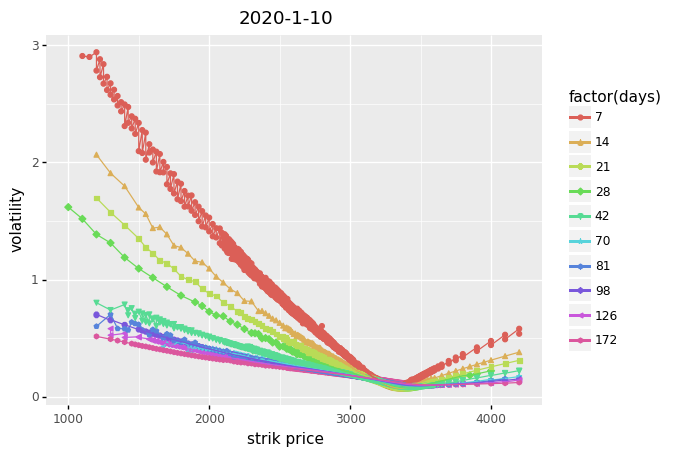

<ggplot: (138178552354)>

In [20]:
p1 = (
    ggplot(option_df_20200110_c_new_part,aes(x='strike_price',y='impl_volatility', color='factor(days)',group = 'factor(days)',shape='factor(days)'))
    + geom_point() 
    + geom_line() 
    + xlab("strik price") 
    + ylab("volatility") 
    + ggtitle("2020-1-10") 
)
p1


In [21]:
ggsave(p1,'D:\Desktop\RND\p1.png')

C:\Anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:\Desktop\RND\p1.png


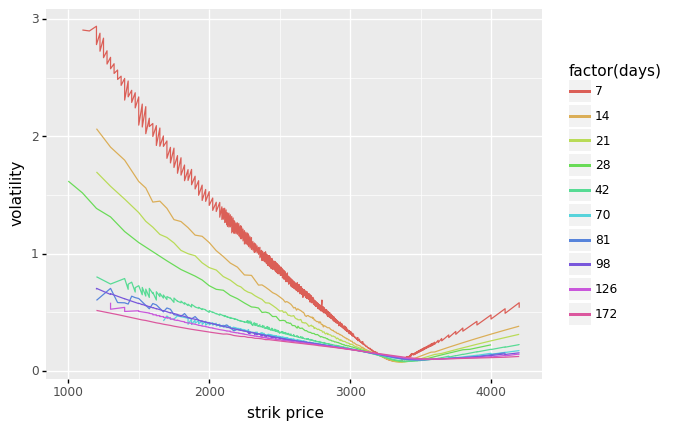

<ggplot: (138139009136)>

In [14]:
#和上面一样 ，不要点
p2 = (
    ggplot(option_df_20200110_c_new_part,aes(x='strike_price',y='impl_volatility', color='factor(days)',group = 'factor(days)'))
    + geom_line() 
    + xlab("strik price") 
    + ylab("volatility") 
)
p2

In [15]:
option_df_20200110_c_new_part = option_df_20200110_c_new_part.reset_index(drop=True)
option_df_20200110_c_new_part_vol = [
    find_vol(option_df_20200110_c_new_part['price'][i], 'c',
             option_df_20200110_c_new_part['St'][i],
             option_df_20200110_c_new_part['strike_price'][i],
             option_df_20200110_c_new_part['tau'][i],
             option_df_20200110_c_new_part['rate'][i])
    for i in range(option_df_20200110_c_new_part.shape[0])
]

C:\Users\dell\AppData\Local\Temp/ipykernel_24940/809980230.py:31: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\dell\AppData\Local\Temp/ipykernel_24940/809980230.py:5: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\dell\AppData\Local\Temp/ipykernel_24940/809980230.py:14: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\dell\AppData\Local\Temp/ipykernel_24940/809980230.py:5: RuntimeWarning: overflow encountered in double_scalars
C:\Users\dell\AppData\Local\Temp/ipykernel_24940/809980230.py:14: RuntimeWarning: overflow encountered in double_scalars
C:\Users\dell\AppData\Local\Temp/ipykernel_24940/809980230.py:31: RuntimeWarning: overflow encountered in double_scalars


In [16]:
option_df_20200110_c_new_part['cal_vol'] = option_df_20200110_c_new_part_vol
#option_df_20200110_c_new_part.to_csv(r'D:\Desktop\RND\option_df_20200110_c_new_part.csv', index = True)

In [17]:
option_df_20200110_c_new_part.columns


Index(['date', 'exdate', 'cp_flag', 'strike_price', 'volume',
       'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'price',
       'time_date', 'time_exdate', 'days', 'tau', 'St', 'nianfen', 'rate',
       'cal_vol'],
      dtype='object')

C:\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 667 rows containing missing values.


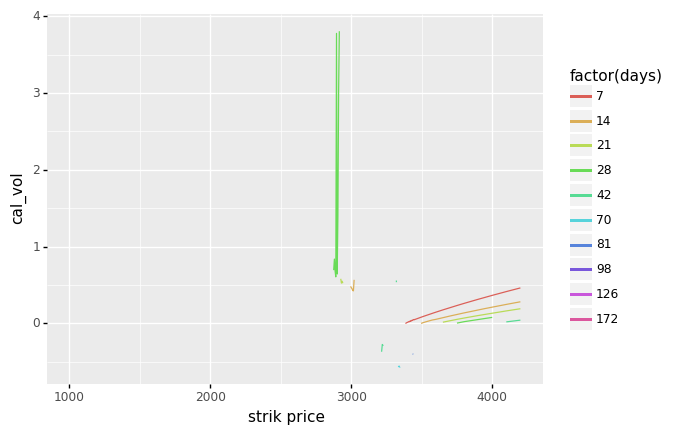

<ggplot: (138138855403)>

In [18]:
p3 = (
    ggplot(option_df_20200110_c_new_part,aes(x='strike_price',y='cal_vol', color='factor(days)',group = 'factor(days)'))
    + geom_line() 
    + xlab("strik price") 
    + ylab("cal_vol") 
)
p3

In [22]:
a = option_df_20200110_c_new_part[option_df_20200110_c_new_part['volume']>0]

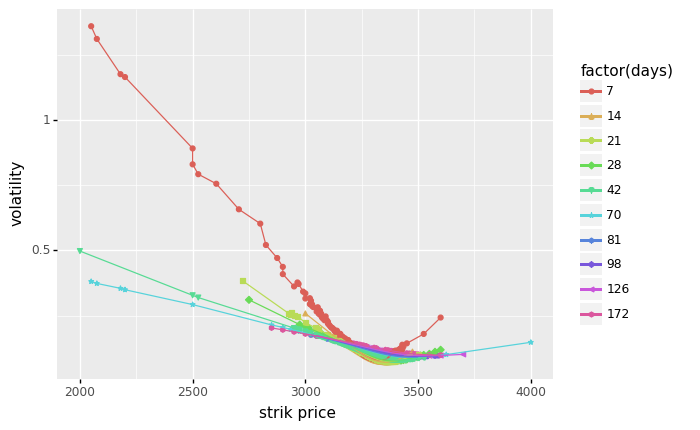

<ggplot: (138178882115)>

In [23]:
p4 = (
    ggplot(a,aes(x='strike_price',y='impl_volatility', color='factor(days)',group = 'factor(days)',shape='factor(days)'))
    + geom_point() 
    + geom_line() 
    + xlab("strik price") 
    + ylab("volatility") 
 
)
p4

C:\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 731 rows containing missing values.
C:\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 255 rows containing missing values.


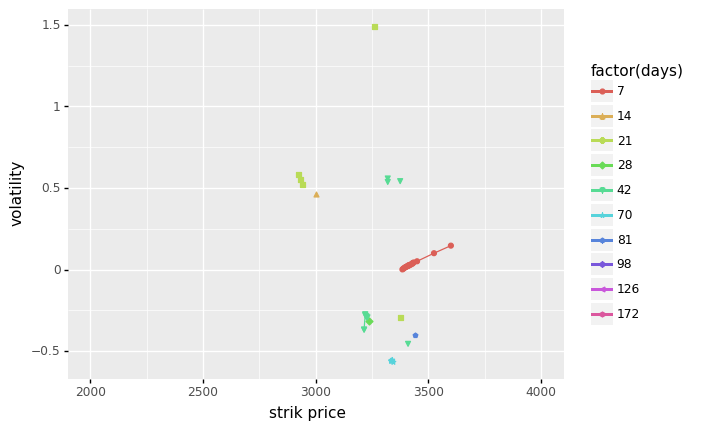

<ggplot: (138179461398)>

In [24]:
p4 = (
    ggplot(a,aes(x='strike_price',y='cal_vol', color='factor(days)',group = 'factor(days)',shape='factor(days)'))
    + geom_point() 
    + geom_line() 
    + xlab("strik price") 
    + ylab("volatility") 
 
)
p4